# Chapter 3: Multi-cell, single population network (with BioNet)

In this tutorial, we will create a more complex network that contains multiple biophysical cells, but all of them having the same cell-type (we will cover hetergenous networks in the next tutorial). The network will contain recurrent connections, as well as external input that provide the next with stimululation.

**Note** - scripts and files for running this tutorial can be found in the directory [sources/chapter03/](sources/chapter03)

requirements:
* bmtk
* NEURON 7.4

## 1. Building the Network

First we will build our internal network, which consists of 100 different cells. All the cells are of the same type (we'll show how to build a heterogeneous network in the next tutorial), however they all have a different location and y-axis rotation.

#### nodes 

In [3]:
import numpy as np
from bmtk.builder.networks import NetworkBuilder
from bmtk.builder.auxi.node_params import positions_columinar, xiter_random

cortex = NetworkBuilder('mcortex')
cortex.add_nodes(N=100,
                 pop_name='Scnn1a',
                 positions=positions_columinar(N=100, center=[0, 50.0, 0], max_radius=30.0, height=100.0),
                 rotation_angle_yaxis=xiter_random(N=100, min_x=0.0, max_x=2*np.pi),
                 rotation_angle_zaxis=3.646878266,
                 potental='exc',
                 model_type='biophysical',
                 model_template='ctdb:Biophys1.hoc',
                 model_processing='aibs_perisomatic',
                 dynamics_params='472363762_fit.json',
                 morphology='Scnn1a_473845048_m.swc')


The parameter N is used to indicate the number of cells in our population. The positions of each cell is defined by the columinar built-in method, which will random place our cells in a column (users can define their own positions as shown here). The rotation_angel_yaxis is similarl defined by a built-in function that will randomly assign each cell a given y angle.

One thing to note is that while yaxis is defined by a function which returns a lists of values, the zaxis is defined by a single value. This means that all cells will share the zaxis. we could alteratively give all cells the same y-axis rotation:
```python
    rotation_angle_yaxis=rotation_value
```
or give all cells a unique z-rotation angle
```python
    rotation_angle_zaxis=xiter_random(N=100, min_x=0.0, max_x=2*np.pi)
```
and in general, it is at the discretion of the modeler to choose what parameters are unqiue to each cell, and what parameters are global to the cell-type.

#### edges

Next we want to add recurrent edges. To create the connections we will use the built-in distance_connector function, which will assign the number of connections between two cells randomly (between range nsyn_min and nsysn_max) but weighted by distance. The other parameters, including the synaptic model (AMPA_ExcToExc) will be shared by all connections.

To use this, or even customized, connection functions, we must pass in the name of our connection function using the "connection_rule" parameter, and the function parameters through "connection_params" as a dictionary, which will looks something like:
```python
    connection_rule=<name_of_function>
    connection_params={'param_arg1': val1, 'param_arg2': val2, ...}
```
The connection_rule method isn't explicitly called by the script. Rather when the build() method is called, the connection_rule will iterate through every source/target node pair, and use the rule and build a connection matrix.


After building the connections based on our connection function, we will save the nodes and edges files into the network/ directory.

In [4]:
from bmtk.builder.auxi.edge_connectors import distance_connector

cortex.add_edges(source={'pop_name': 'Scnn1a'}, target={'pop_name': 'Scnn1a'},
                 connection_rule=distance_connector,
                 connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.34, 'd_max': 50.0, 'nsyn_min': 0, 'nsyn_max': 10},
                 syn_weight=2.0e-04,
                 distance_range=[30.0, 150.0],
                 target_sections=['basal', 'apical', 'soma'],
                 delay=2.0,
                 dynamics_params='AMPA_ExcToExc.json',
                 model_template='exp2syn')



In [5]:
%%bash
rm network/*

If you get the output:

rm: cannot remove 'network/*': No such file or directory

It's OK. Keep going.

In [6]:
cortex.build()
cortex.save_nodes(output_dir='network')
cortex.save_edges(output_dir='network')

### External network

After building our internal network, we will build the external thalamic network which will provide input (see previous tutorial for more detail). Our thalamic network will consist of 100 "filter" cells, which aren't actual cells by just place holders for spike-trains.

In [7]:
thalamus = NetworkBuilder('mthalamus')
thalamus.add_nodes(N=100,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')

The external network doesn't have recurrent connections. Rather all the cells are feedforward onto the internal network. To do this is in a separate script which must reload the saved mcortex cell files using the import function. Then we create an edge with the thalamus nodes as the sources and the cortext nodes as the targets. This time we use the built-in connect_random connection rule, which will randomly assign each thalamus --> cortex connection between 0 and 12 synaptic connections.

In [8]:
from bmtk.builder.auxi.edge_connectors import connect_random

thalamus.add_edges(source=thalamus.nodes(), target=cortex.nodes(),
                   connection_rule=connect_random,
                   connection_params={'nsyn_min': 0, 'nsyn_max': 12},
                   syn_weight=1.0e-04,
                   distance_range=[0.0, 150.0],
                   target_sections=['basal', 'apical'],
                   delay=2.0,
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='exp2syn')

thalamus.build()
thalamus.save_nodes(output_dir='network')
thalamus.save_edges(output_dir='network')

## 2. Setting up BioNet

#### file structure.

Before running a simulation, we will need to create the runtime environment, including parameter files, run-script and configuration files. If using the tutorial these files will already be in place, however you should run the following anyway in a command-line:
```bash
 $ python -m bmtk.utils.sim_setup -n network --membrane_report-vars v,cai --membrane_report-sections soma --tstop 3000.0 --dt 0.1 bionet
```

Also our cortex cell uses a Scnn1a model we can download from the Allen Cell-Types Database (same as Chapter 1 & 2)
```bash
 $ wget http://celltypes.brain-map.org/neuronal_model/download/482934212
 $ unzip 482934212
 $ cp fit_parameters.json biophys_components/biophysical_neuron_templates/472363762_fit.json
 $ cp reconstruction.swc biophys_components/morphologies/Scnn1a_473845048_m.swc
```

#### Spike Trains

We next need to create a csv (or nwb) file containing spike trains for our thalamic filter cells. Then we must edit the "input" section of the config file to reflect where input spikes are coming from.

In [9]:
from bmtk.utils.spike_trains import SpikesGenerator

sg = SpikesGenerator(nodes='network/mthalamus_nodes.h5', t_max=3.0)
sg.set_rate(15.0)
sg.save_csv('thalamus_spikes.csv', in_ms=True)

```json
"inputs": {
    "tc_spikes": {
      "input_type": "spikes",
      "module": "csv",
      "input_file": "${BASE_DIR}/thalamus_spikes.csv",
      "node_set": "mthalamus"
    }
}
```

## 3. Running the simulation

Once our config file is setup we can run a simulation either through the command line:
```bash
$ python run_bionet.py simulation_config.json
```

or through the script

In [1]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2018-09-20 15:59:16,953 [INFO] Created log file
2018-09-20 15:59:17,128 [INFO] Building cells.
2018-09-20 15:59:22,347 [INFO] Building recurrent connections
2018-09-20 15:59:22,962 [INFO] Build virtual cell stimulations for tc_spikes
2018-09-20 15:59:30,596 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2018-09-20 15:59:30,598 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2018-09-20 15:59:30,599 [INFO] Block save every 5000 steps
2018-09-20 15:59:52,769 [INFO]     step:5000 t_sim:500.00 ms
2018-09-20 16:00:14,740 [INFO]     step:10000 t_sim:1000.00 ms
2018-09-20 16:00:36,662 [INFO]     step:15000 t_sim:1500.00 ms
2018-09-20 16:00:58,599 [INFO]     step:20000 t_sim:2000.00 ms
2018-09-20 16:01:20,658 [INFO]     step:25000 t_sim:2500.00 ms
2018-09-20 16:01:43,358 [INFO]     step:30000 t_sim:3000.00 ms
2018-09-20 16:01:44,182 [INFO] Simulation completed in 2.0 minutes, 13.59 seconds 


## 4. Analyzing the run.

If successful, we should have our results in the 'output' directory. We can use the analyzer to plot a raster of the spikes over time:

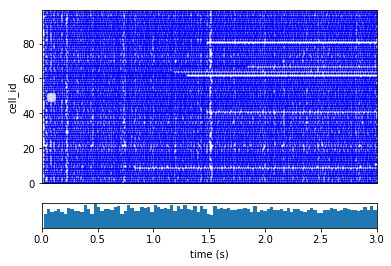

In [11]:
from bmtk.analyzer.spike_trains import raster_plot

raster_plot(cells_file='network/mcortex_nodes.h5', cell_models_file='network/mcortex_node_types.csv', spikes_file='output/spikes.h5')

In our config file we used the cell_vars and node_id_selections parameters to save the calcium influx and membrane potential of selected cells. We can also use the analyzer to display these traces:

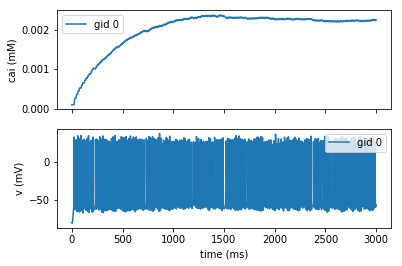

In [12]:
from bmtk.analyzer.cell_vars import plot_report

plot_report(config_file='simulation_config.json', gids=[0])

## 5. Modifying the network

### Customized node params

When building our cortex nodes, we used some built-in functions to set certain parameters like positions and y-axis rotations:
```python
cortex.add_nodes(N=100,
                 pop_name='Scnn1a',
                 positions=positions_columinar(N=100, center=[0, 50.0, 0], max_radius=30.0, height=100.0),
                 rotation_angle_yaxis=xiter_random(N=100, min_x=0.0, max_x=2*np.pi),
                 ...
```

These functions will assign every cell a unique value in the positions and rotation_angle_yaxis parameters, unlike the pop_name parameter which will be the same for all 100 cells. We can verify by the following code:


In [20]:
cortex_nodes = list(cortex.nodes())
n0 = cortex_nodes[0]
n1 = cortex_nodes[1]
print('cell 0: pop_name: {}, positions: {}, angle_yaxis: {}'.format(n0['pop_name'], n0['positions'], n0['rotation_angle_yaxis']))
print('cell 1: pop_name: {}, positions: {}, angle_yaxis: {}'.format(n1['pop_name'], n1['positions'], n1['rotation_angle_yaxis']))


cell 0: pop_name: Scnn1a, positions: [ -1.99484437  41.49527042  22.33923077], angle_yaxis: 5.29759513272
cell 1: pop_name: Scnn1a, positions: [-25.72073426  36.01835631   2.43526216], angle_yaxis: 2.94311607964


The Network Builder contains a growing number of built-in functions. However for advanced networks a modeler will probably want to assign parameters using their own functions. To do so, a modeler only needs to passes in, or alternatively create a function that returns, a list of size N. When saving the network, each individual position will be saved in the nodes.h5 file assigned to each cell by gid.

```python
def cortex_positions(N):
    # codex to create a list/numpy array of N (x, y, z) positions.
    return [...]

cortex.add_nodes(N=100,
                 positions=cortex_positions(100),
                 ...
```

or if we wanted we could give all cells the same position (The builder has no restrictions on this, however this may cause issues if you're trying to create connections based on distance). When saving the network, the same position is assigned as a global cell-type property, and thus saved in the node_types.csv file.
```python
cortex.add_nodes(N=100,
                 positions=np.ndarray([100.23, -50.67, 89.01]),
                 ...
```

We can use the same logic not just for positions and rotation_angle, but for any parameter we choose.

### Customized connector functions

When creating edges, we used the built-in distance_connector function to help create the connection matrix. There are a number of built-in connection functions, but we also allow modelers to create their own. To do so, the modeler must create a function that takes in a source, target, and a variable number of parameters, and pass back a natural number representing the number of connections.

The Builder will iterate over that function passing in every source/target node pair (filtered by the source and target parameters in add_edges()). The source and target parameters are essentially dictionaries that can be used to fetch properties of the nodes. A typical example would look like:

```python
def customized_connector(source, target, param1, param2, param3):
    if source.node_id == target.node_id:
        # necessary if we don't want autapses
        return 0
    source_pot = source['potential']
    target_pot = target['potential']
    # some code to determine number of connections
    return n_synapses
    
...
cortex.add_edges(source=<source_nodes>, target=<target_nodes>,
                 connection_rule=customized_connector,
                 connection_params={'param1': <p1>, 'param2': <p2>, 'param3': <p3>},
                 ...
```